In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#  Path to your dataset
file_path = "C:/Dataset/1.csv"#it is done by panda 

# Load dataset
if os.path.exists(file_path):
    data = pd.read_csv(file_path)
    print(" Dataset loaded successfully!")
else:
    print(" File not found. Check the path:", file_path)

# Display dataset info
print("\n Dataset Info:")
print(data.info())# it is done by panda 

# Display missing values
print("\n Missing Values:")
print(data.isnull().sum().sort_values(ascending=False))# done by panda data not found =(1,true) data found =(0,false) and
#then calc the sum of column and the sort the col missing in asc order


 Dataset loaded successfully!

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13812 entries, 0 to 13811
Data columns (total 79 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient_ID                            13812 non-null  int64  
 1   Age                                   13812 non-null  int64  
 2   Gender                                13812 non-null  object 
 3   Diagnosis                             13812 non-null  object 
 4   Sickness_Duration_Months              13812 non-null  int64  
 5   RBC_Count                             13812 non-null  float64
 6   Hemoglobin                            13812 non-null  float64
 7   Hematocrit                            13812 non-null  float64
 8   MCV                                   13812 non-null  float64
 9   MCH                                   13812 non-null  float64
 10  MCHC                                

In [2]:
# Statistical summary of numeric columns done by pandas
data.describe()

# Explore unique values in categorical columns like Gender and Diagnosis
data['Gender'].value_counts()
data['Diagnosis'].value_counts()

Diagnosis
Autoimmune orchitis                   2490
Systemic lupus erythematosus (SLE)    2390
Rheumatoid arthritis                  2310
Normal                                2230
Sjögren syndrome                      2200
Graves' disease                       2192
Name: count, dtype: int64

In [3]:
from sklearn.preprocessing import LabelEncoder #in sklearn we are calling for preprocessing . in sklearn calling 
# specific tool LebelEncoder
#lebelencoder convert word into number
# Encoding Gender and Diagnosis columns
data['Gender'] = LabelEncoder().fit_transform(data['Gender']) #fit: The encoder first looks at the entire Gender column for unique values. 
#It finds 'Male' and 'Female' and creates an internal mapping, like a dictionary: {'Female': 0, 'Male': 1}.
#transform : it goes through the Gender column again, row by row, and replaces each word with the corresponding number F:0,M:1.
#scikit-learn tool to convert the 'Gender' column from text ('Male', 'Female') into numbers (1, 0), and then telling Pandas to update the DataFrame with this new numerical column.
data['Diagnosis'] = LabelEncoder().fit_transform(data['Diagnosis'])
#It learns the unique diagnosis names (e.g., 'Rheumatoid Arthritis', 'Lupus', 'Psoriasis', etc.).
#It assigns a unique number to each one (e.g., 0, 1, 2, ...).

Text(0.5, 1.0, 'Diagnosis Distribution')

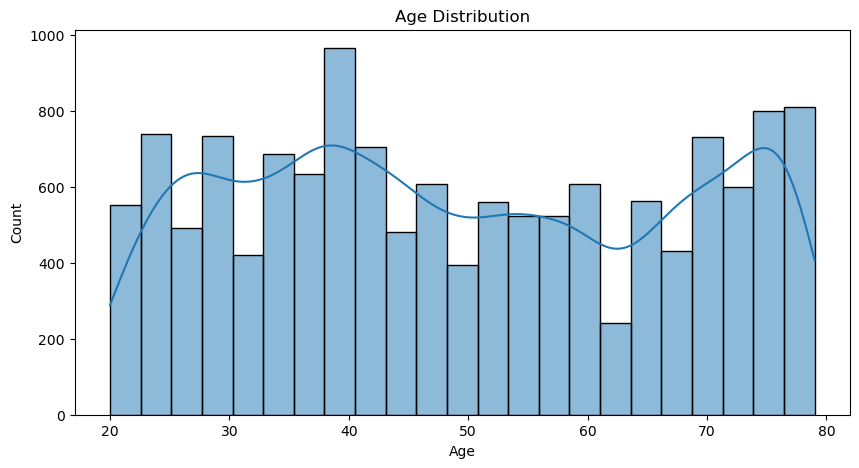

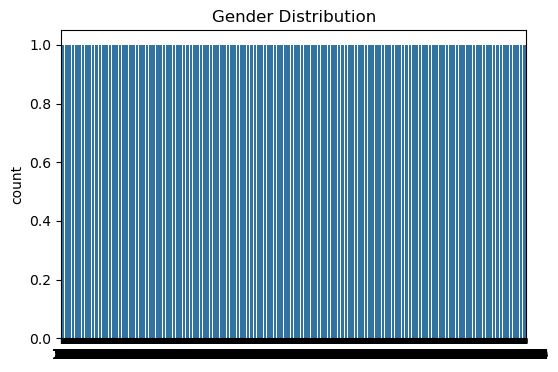

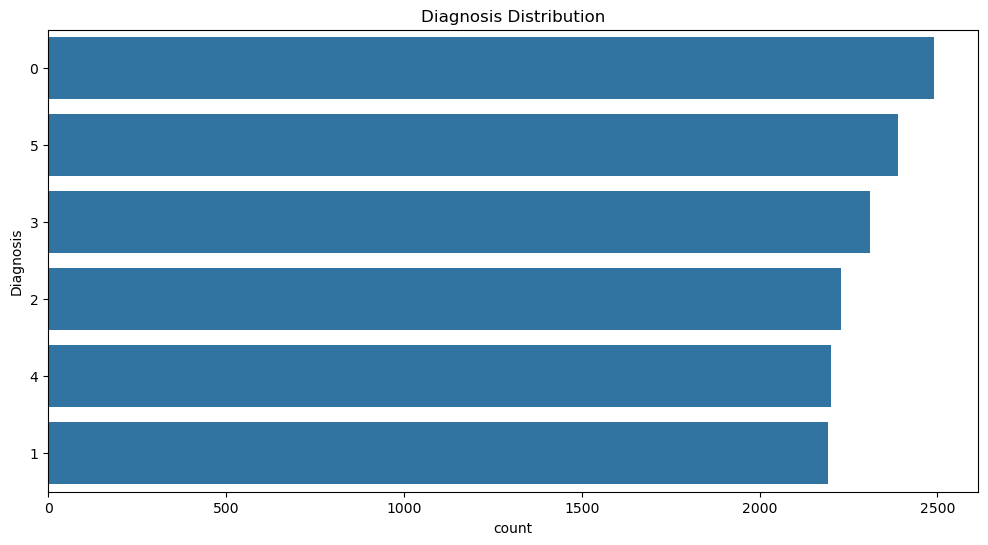

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['Age'], kde=True)
plt.title('Age Distribution')

# Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data['Gender'])
plt.title('Gender Distribution')

# Diagnosis Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Diagnosis', data=data, order=data['Diagnosis'].value_counts().index)
plt.title('Diagnosis Distribution')

Text(0.5, 1.0, 'Correlation Matrix of Clinical Features')

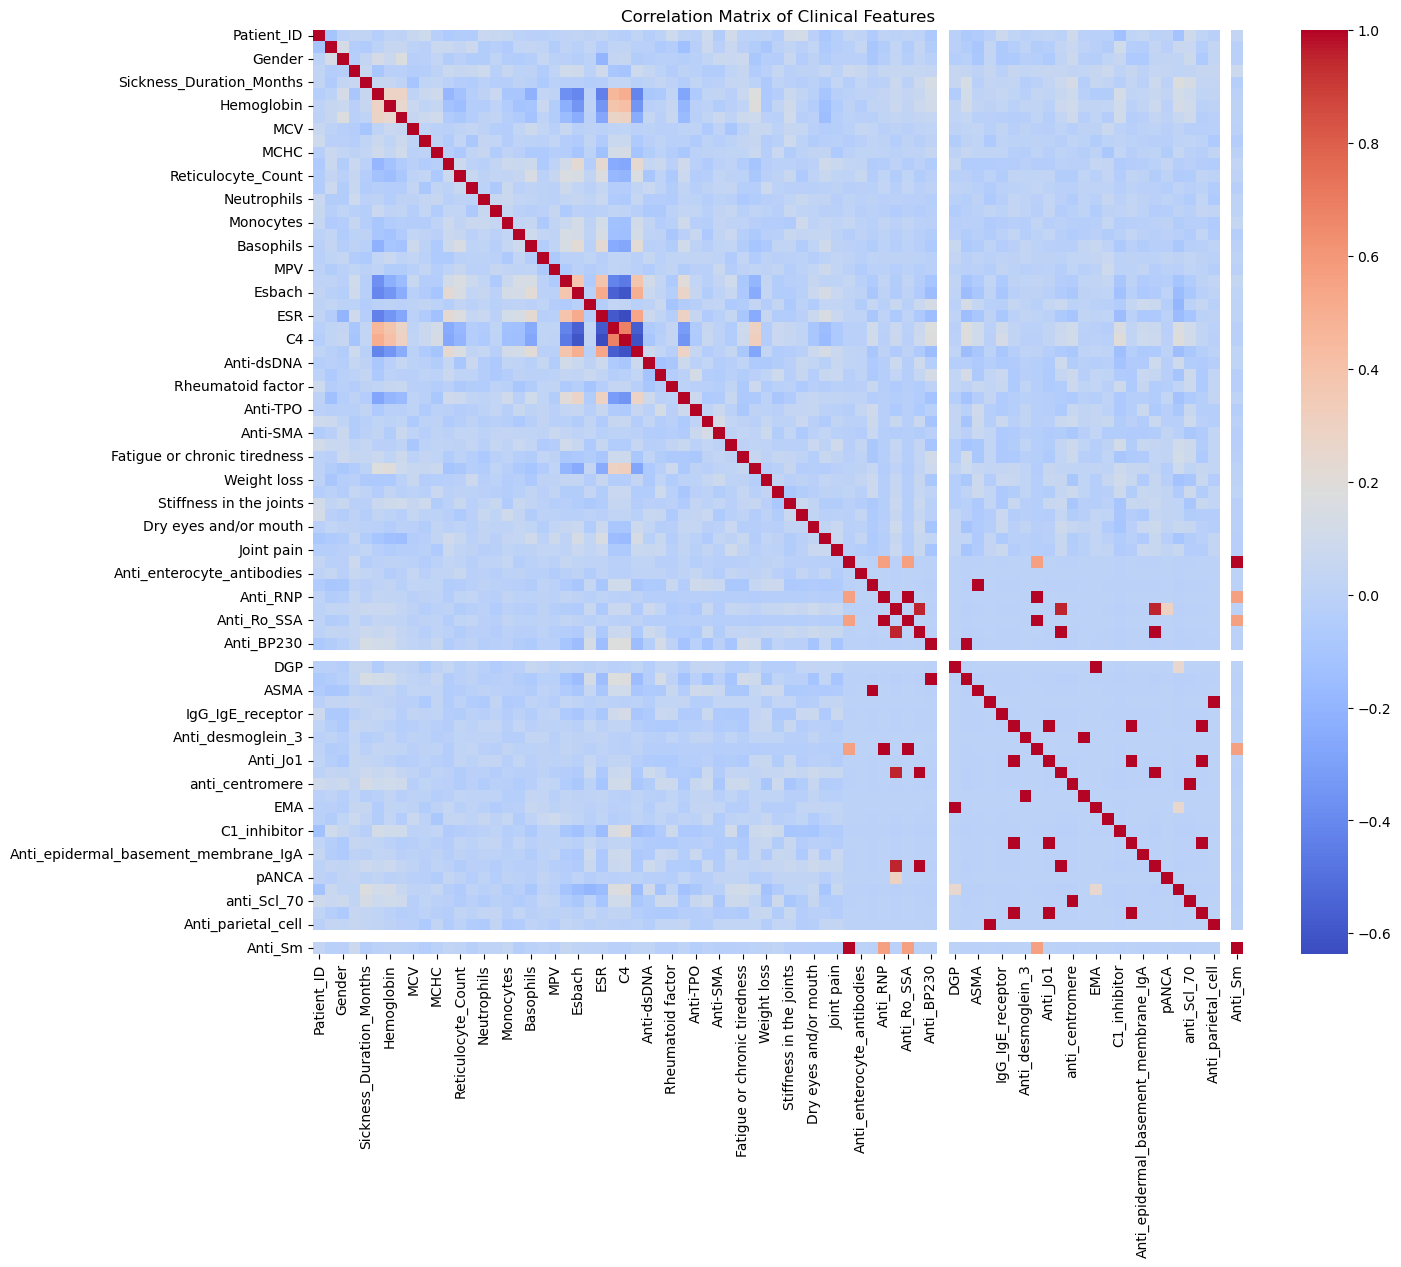

In [5]:
# Heatmap of correlations
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title('Correlation Matrix of Clinical Features')

Text(0.5, 1.0, 'RBC Count vs Hemoglobin by Diagnosis')

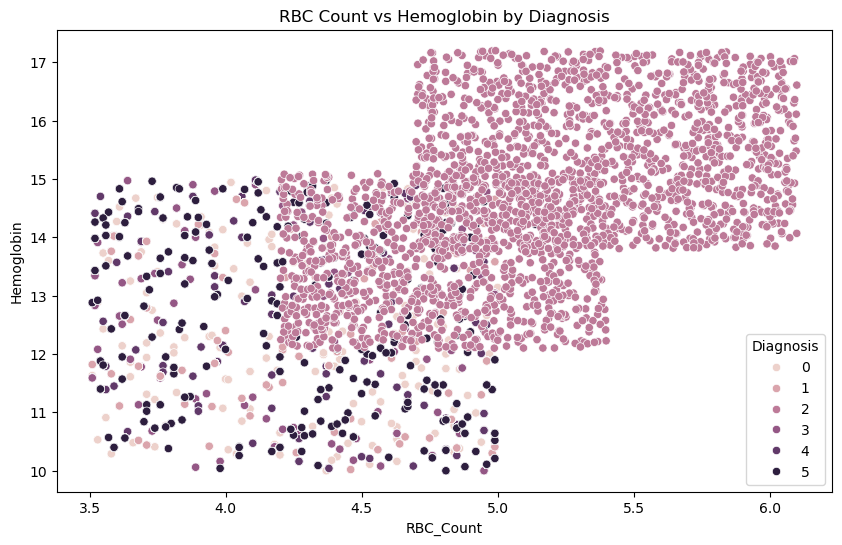

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RBC_Count', y='Hemoglobin', hue='Diagnosis', data=data)
plt.title('RBC Count vs Hemoglobin by Diagnosis')

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert Diagnosis column to list of lists format, where each label is a list (even if single)
data['Diagnosis'] = data['Diagnosis'].apply(lambda x: [x])

# Use MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['Diagnosis'])
disease_classes = mlb.classes_

# Verify the result
print(y.shape)  # Should have shape (num_samples, num_classes)

(13812, 6)


In [8]:
import sys
print(sys.executable)


C:\Users\sudha\anaconda3\python.exe


In [9]:
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
# Import AdamW from torch.optim instead of transformers
from torch.optim import AdamW  # Changed import location
import torch.nn as nn

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np

# Split the features and labels
features = data.drop(columns=['Diagnosis'])  # Drop target column
labels = y  # Multi-label target from previous step

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [11]:
class AutoimmuneDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create DataLoader objects
train_dataset = AutoimmuneDataset(X_train, y_train)
val_dataset = AutoimmuneDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [12]:
class MultiLabelNN(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.out(x), dim=1)  # Using softmax here

# Initialize the model
model = MultiLabelNN(input_dim=X_train.shape[1], n_classes=labels.shape[1])

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [14]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch in data_loader:
        features = batch['features'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Return the average loss per batch
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [15]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def evaluate_epoch(model, data_loader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Apply threshold to get binary predictions
            preds = (outputs > threshold).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = total_loss / len(data_loader)

    # Flatten lists to arrays for metric calculation
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute additional metrics
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)

    # Return metrics and the collected labels and predictions
    return {
        "val_loss": avg_loss,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "all_labels": all_labels,
        "all_preds": all_preds
    }

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 200  # Adjust as necessary

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_f1_scores = []
val_accuracies = []
all_labels = []
all_preds = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_metrics = evaluate_epoch(model, val_loader, criterion, device)

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_metrics["val_loss"])
    val_f1_scores.append(val_metrics["f1_micro"])
    val_accuracies.append(val_metrics["accuracy"])

    # Store the all_labels and all_preds for confusion matrix after training
    all_labels = val_metrics["all_labels"]
    all_preds = val_metrics["all_preds"]

    # Print metrics for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_metrics['val_loss']:.4f}, Val F1 Score: {val_metrics['f1_micro']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")

Epoch 1/200
Train Loss: 0.4514
Val Loss: 0.4474, Val F1 Score: 0.0000, Accuracy: 0.0000
Epoch 2/200
Train Loss: 0.4435
Val Loss: 0.4390, Val F1 Score: 0.0000, Accuracy: 0.0000
Epoch 3/200
Train Loss: 0.4329
Val Loss: 0.4266, Val F1 Score: 0.0000, Accuracy: 0.0000
Epoch 4/200
Train Loss: 0.4178
Val Loss: 0.4097, Val F1 Score: 0.0321, Accuracy: 0.0163
Epoch 5/200
Train Loss: 0.3992
Val Loss: 0.3910, Val F1 Score: 0.2163, Accuracy: 0.1212
Epoch 6/200
Train Loss: 0.3811
Val Loss: 0.3751, Val F1 Score: 0.2774, Accuracy: 0.1611
Epoch 7/200
Train Loss: 0.3672
Val Loss: 0.3637, Val F1 Score: 0.2854, Accuracy: 0.1665
Epoch 8/200
Train Loss: 0.3575
Val Loss: 0.3555, Val F1 Score: 0.2918, Accuracy: 0.1708
Epoch 9/200
Train Loss: 0.3503
Val Loss: 0.3493, Val F1 Score: 0.2960, Accuracy: 0.1737
Epoch 10/200
Train Loss: 0.3447
Val Loss: 0.3443, Val F1 Score: 0.2997, Accuracy: 0.1763
Epoch 11/200
Train Loss: 0.3401
Val Loss: 0.3400, Val F1 Score: 0.3007, Accuracy: 0.1770
Epoch 12/200
Train Loss: 0.336

In [17]:
import numpy as np
import torch

def get_predictions(model, data_loader, device, threshold=0.5):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            features = batch['features'].to(device)

            # Forward pass to get model outputs
            outputs = model(features)

            # Apply threshold to get binary predictions
            preds = (outputs > threshold).int().cpu().numpy()
            all_preds.extend(preds)

    # Convert predictions to a numpy array
    all_preds = np.array(all_preds)
    return all_preds

In [18]:
# Define the mapping from label index to disease name
label_mapping = {
    0: "Autoimmune orchitis",
    1: "Graves' disease",
    2: "Sjögren syndrome",
    3: "Rheumatoid arthritis",
    4: "Normal",
    5: "Systemic lupus erythematosus (SLE)"
}

In [19]:
# Use get_predictions function to get binary predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = get_predictions(model, train_loader, device)  # or val_loader

# Convert predictions to disease names using label_mapping
predicted_labels = []
for sample in predictions:
    diseases = [label_mapping[idx] for idx, label in enumerate(sample) if label == 1]
    predicted_labels.append(diseases if diseases else ["No labels predicted"])

# Display the results
for i, labels in enumerate(predicted_labels):
    print(f"Sample {i+1}: {', '.join(labels)}")

Sample 1: Systemic lupus erythematosus (SLE)
Sample 2: Normal
Sample 3: Sjögren syndrome
Sample 4: Systemic lupus erythematosus (SLE)
Sample 5: Autoimmune orchitis
Sample 6: Systemic lupus erythematosus (SLE)
Sample 7: Sjögren syndrome
Sample 8: Rheumatoid arthritis
Sample 9: Sjögren syndrome
Sample 10: Sjögren syndrome
Sample 11: Systemic lupus erythematosus (SLE)
Sample 12: Rheumatoid arthritis
Sample 13: Autoimmune orchitis
Sample 14: Autoimmune orchitis
Sample 15: Sjögren syndrome
Sample 16: Graves' disease
Sample 17: Graves' disease
Sample 18: Autoimmune orchitis
Sample 19: Normal
Sample 20: Autoimmune orchitis
Sample 21: Graves' disease
Sample 22: Rheumatoid arthritis
Sample 23: Sjögren syndrome
Sample 24: Rheumatoid arthritis
Sample 25: Sjögren syndrome
Sample 26: Sjögren syndrome
Sample 27: Normal
Sample 28: Rheumatoid arthritis
Sample 29: Rheumatoid arthritis
Sample 30: Autoimmune orchitis
Sample 31: Systemic lupus erythematosus (SLE)
Sample 32: Graves' disease
Sample 33: Auto

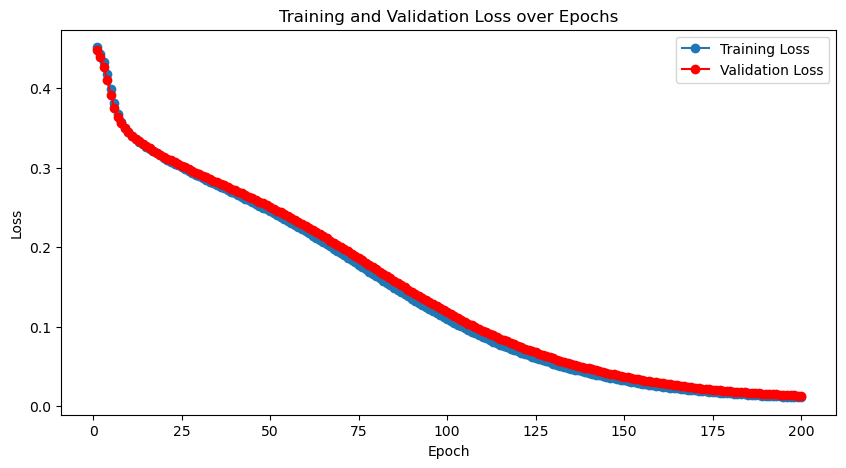

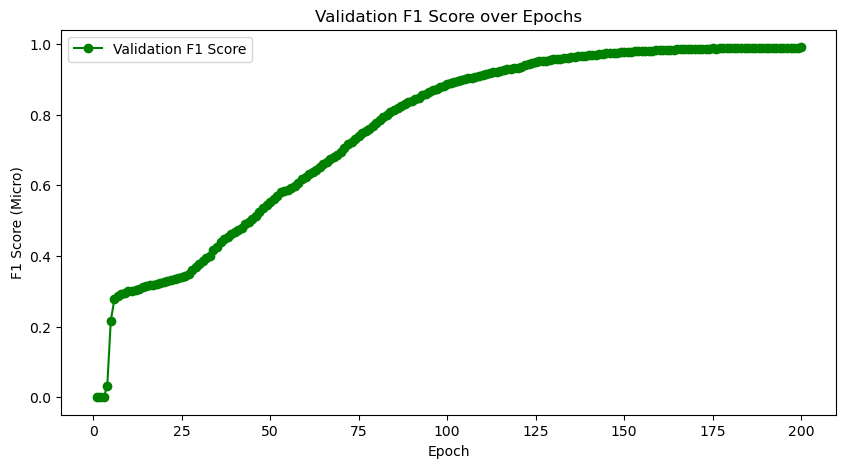

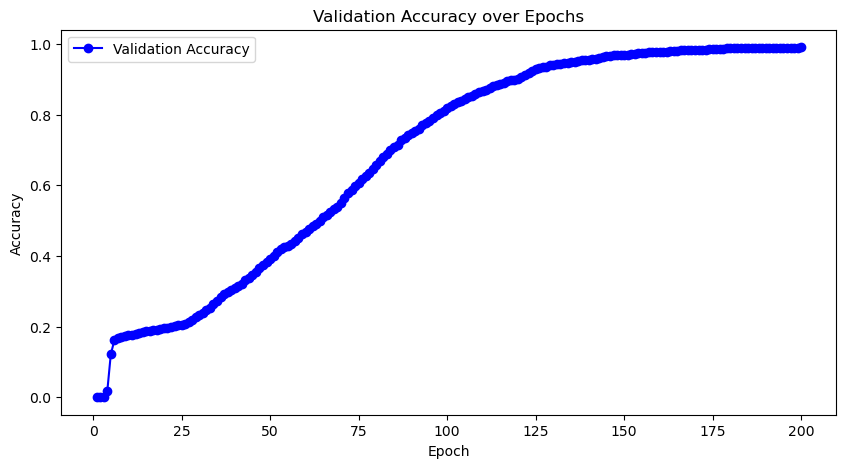

In [20]:
import matplotlib.pyplot as plt

# Define the range of epochs
epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot Validation F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('Validation F1 Score over Epochs')
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [23]:
torch.save(model.state_dict(), "C:/abcd/disease_model.pth")
